In [39]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
from tensorflow.keras.layers import Normalization, Dense, InputLayer
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

## Data Preperation

In [40]:
import os
os.environ['eda'] = "False"

In [41]:
df = pd.read_csv("/content/second-hand-car.csv")

In [42]:
df.head()

,v.id,on road old,on road now,years,km,rating,condition,economy,top speed,hp,torque,current price
0,1,535651,798186,3,78945,1,2,14,177,73,123,351318.0
1,2,591911,861056,6,117220,5,9,9,148,74,95,285001.5
2,3,686990,770762,2,132538,2,8,15,181,53,97,215386.0
3,4,573999,722381,4,101065,4,3,11,197,54,116,244295.5
4,5,691388,811335,6,61559,3,9,12,160,53,105,531114.5


In [43]:
print(df.columns)

Index(['v.id', 'on road old', 'on road now', 'years', 'km', 'rating',
       'condition', 'economy', 'top speed', 'hp', 'torque', 'current price'],
      dtype='object')


In [44]:
df.shape

(1000, 12)

In [45]:
if os.environ['eda'] == "True":
  sns.pairplot(df[['on road old', 'on road now', 'years', 'km', 'rating',
       'condition', 'economy', 'top speed', 'hp', 'torque', 'current price']], diag_kind='kde')

In [46]:
tensor_data = tf.constant(df)
print(tensor_data.shape)

(1000, 12)


In [47]:
print(tensor_data)

tf.Tensor(
[[1.000000e+00 5.356510e+05 7.981860e+05 ... 7.300000e+01 1.230000e+02
  3.513180e+05]
 [2.000000e+00 5.919110e+05 8.610560e+05 ... 7.400000e+01 9.500000e+01
  2.850015e+05]
 [3.000000e+00 6.869900e+05 7.707620e+05 ... 5.300000e+01 9.700000e+01
  2.153860e+05]
 ...
 [9.980000e+02 6.463440e+05 8.427330e+05 ... 1.130000e+02 8.900000e+01
  4.058710e+05]
 [9.990000e+02 5.355590e+05 7.324390e+05 ... 1.120000e+02 1.280000e+02
  7.439800e+04]
 [1.000000e+03 5.901050e+05 7.797430e+05 ... 9.900000e+01 9.600000e+01
  4.149385e+05]], shape=(1000, 12), dtype=float64)


In [48]:
tensor_data = tf.random.shuffle(tensor_data)
print(tensor_data[:5])

tf.Tensor(
[[3.880000e+02 5.104020e+05 7.212560e+05 3.000000e+00 5.908900e+04
  3.000000e+00 1.000000e+00 1.000000e+01 1.710000e+02 1.020000e+02
  1.300000e+02 3.797250e+05]
 [4.210000e+02 5.522800e+05 8.982900e+05 2.000000e+00 1.298910e+05
  5.000000e+00 2.000000e+00 1.100000e+01 1.440000e+02 5.700000e+01
  7.200000e+01 2.074805e+05]
 [8.910000e+02 5.337740e+05 8.707360e+05 6.000000e+00 7.026100e+04
  5.000000e+00 7.000000e+00 1.400000e+01 1.880000e+02 9.900000e+01
  1.190000e+02 4.275900e+05]
 [2.100000e+01 5.609760e+05 7.190030e+05 7.000000e+00 1.305230e+05
  5.000000e+00 5.000000e+00 1.000000e+01 1.870000e+02 7.500000e+01
  1.290000e+02 1.128645e+05]
 [4.340000e+02 5.244730e+05 7.722320e+05 3.000000e+00 1.248330e+05
  4.000000e+00 7.000000e+00 1.000000e+01 1.970000e+02 5.500000e+01
  8.200000e+01 1.580315e+05]], shape=(5, 12), dtype=float64)


In [49]:
X = tensor_data[:, 3:-1]
print(X.shape)

(1000, 8)


In [60]:
y = tensor_data[:, -1]
y = tf.expand_dims(y, axis=-1) # to make it a 2d tensor
print(y.shape)

(1000,)
(1000, 1)


In [51]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
DATASET_SIZE = len(X)

In [52]:
X_train = X[:int(DATASET_SIZE*TRAIN_RATIO)]
y_train = y[:int(DATASET_SIZE*TRAIN_RATIO)]
print(X_train.shape)
print(y_train.shape)

(800, 8)
(800, 1)


In [53]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [54]:
X_val = X[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(VAL_RATIO+TRAIN_RATIO))]
y_val = y[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(VAL_RATIO+TRAIN_RATIO))]
print(X_val.shape)
print(y_val.shape)

(100, 8)
(100, 1)


In [55]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [56]:
X_test = X[int(DATASET_SIZE*(VAL_RATIO+TRAIN_RATIO)):int(DATASET_SIZE*(VAL_RATIO+TRAIN_RATIO+TEST_RATIO))]
y_test = y[int(DATASET_SIZE*(VAL_RATIO+TRAIN_RATIO)):int(DATASET_SIZE*(VAL_RATIO+TRAIN_RATIO+TEST_RATIO))]
print(X_test.shape)
print(y_test.shape)

(100, 8)
(100, 1)


In [57]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [61]:
normalizer = Normalization()
normalizer.adapt(X_train) # adapts the mean and variance
normalizer(X_train)
print(X_train[:5, :])

tf.Tensor(
[[3.00000e+00 5.90890e+04 3.00000e+00 1.00000e+00 1.00000e+01 1.71000e+02
  1.02000e+02 1.30000e+02]
 [2.00000e+00 1.29891e+05 5.00000e+00 2.00000e+00 1.10000e+01 1.44000e+02
  5.70000e+01 7.20000e+01]
 [6.00000e+00 7.02610e+04 5.00000e+00 7.00000e+00 1.40000e+01 1.88000e+02
  9.90000e+01 1.19000e+02]
 [7.00000e+00 1.30523e+05 5.00000e+00 5.00000e+00 1.00000e+01 1.87000e+02
  7.50000e+01 1.29000e+02]
 [3.00000e+00 1.24833e+05 4.00000e+00 7.00000e+00 1.00000e+01 1.97000e+02
  5.50000e+01 8.20000e+01]], shape=(5, 8), dtype=float64)


- Sequential API
- Functional API
- Subclass

## Neural Network

In [87]:
model = tf.keras.Sequential([
     InputLayer(input_shape = (8,), batch_size=10),
     normalizer,
     Dense(128, activation = "relu"),
     Dense(128, activation = "relu"),
     Dense(128, activation = "relu"),
     Dense(1),
])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (10, 8)                   17        
 on)                                                             
                                                                 
 dense_8 (Dense)             (10, 128)                 1152      
                                                                 
 dense_9 (Dense)             (10, 128)                 16512     
                                                                 
 dense_10 (Dense)            (10, 128)                 16512     
                                                                 
 dense_11 (Dense)            (10, 1)                   129       
                                                                 
Total params: 34322 (134.07 KB)
Trainable params: 34305 (134.00 KB)
Non-trainable params: 17 (72.00 Byte)
______________

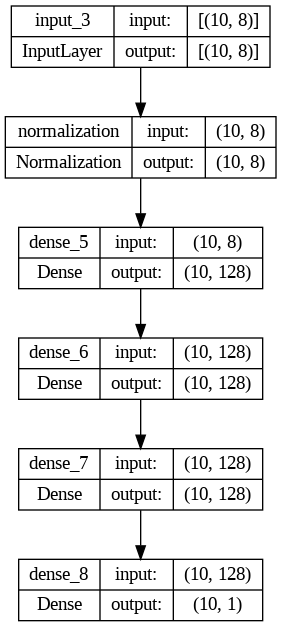

In [ ]:
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True)

### Alternative Method for constructing Neural Network

In [ ]:
"""
model = tf.keras.Sequential()

model.add(normalizer)
model.add(Dense(1)) # Dense (1) will give one output, Dense (n) will give n outputs
print(model.summary())
"""

'\nmodel = tf.keras.Sequential()\n\nmodel.add(normalizer)\nmodel.add(Dense(1)) # Dense (1) will give one output, Dense (n) will give n outputs\nprint(model.summary())\n'

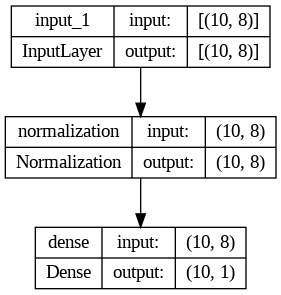

In [ ]:
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True)

## Training & Compiling it

In [88]:
model.compile(loss= MeanAbsoluteError(), optimizer = Adam(learning_rate=0.01), metrics= RootMeanSquaredError())

In [89]:
history = model.fit(train_dataset, validation_data=val_dataset ,epochs=100, verbose=1)

Epoch 1/100
25/25 [==============================] - 1s 9ms/step - loss: 307928.3750 - root_mean_squared_error: 332384.5938 - val_loss: 304686.0625 - val_root_mean_squared_error: 331757.4375
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 252971.9375 - root_mean_squared_error: 284276.3438 - val_loss: 152098.8594 - val_root_mean_squared_error: 186715.2500
Epoch 3/100
25/25 [==============================] - 0s 4ms/step - loss: 84229.8125 - root_mean_squared_error: 108001.7812 - val_loss: 46416.8281 - val_root_mean_squared_error: 58244.4023
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 41944.2695 - root_mean_squared_error: 52080.5586 - val_loss: 40664.1602 - val_root_mean_squared_error: 48623.9102
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 39952.6367 - root_mean_squared_error: 49336.0898 - val_loss: 38545.0703 - val_root_mean_squared_error: 47192.1992
Epoch 6/100
25/25 [==============================] - 0s 

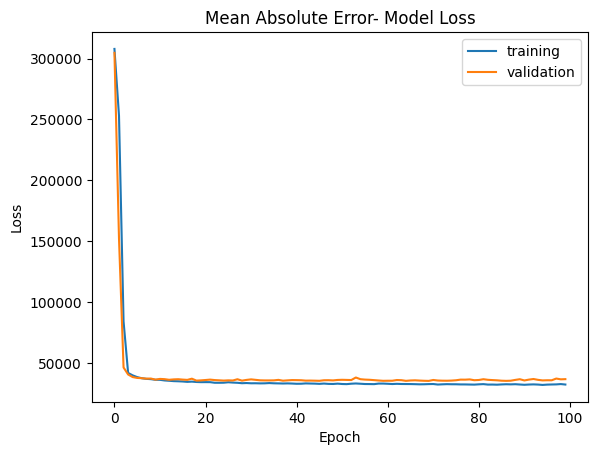

In [90]:
import matplotlib.pyplot as plt

# Assuming `history` is the variable containing the history object
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Mean Absolute Error- Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

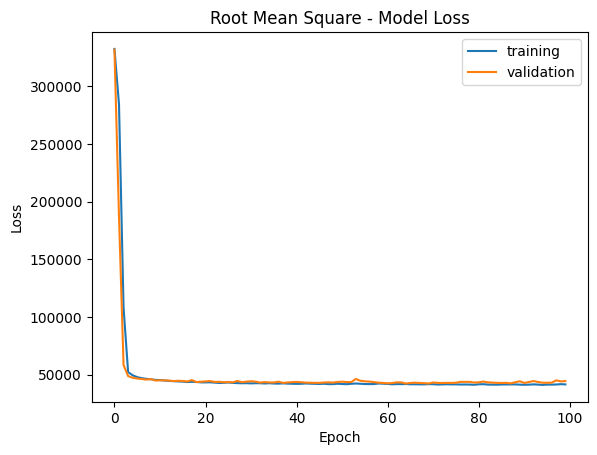

In [91]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Root Mean Square - Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['training', 'validation'] ,loc='upper right')
plt.show()

In [92]:
model.evaluate(X_test, y_test)
# [38018.07421875, 46750.73046875]

4/4 [==============================] - 0s 4ms/step - loss: 35637.9883 - root_mean_squared_error: 45599.3477


[35637.98828125, 45599.34765625]

## Predicting

In [69]:
y_true = list(y_test[:,0].numpy())

In [70]:
y_pred = list(model.predict(X_test)[:, 0])
print(y_pred)

4/4 [==============================] - 0s 3ms/step
[439144.84, 334851.2, 276941.47, 349823.16, 418386.84, 191719.92, 353342.06, 328318.03, 203954.6, 126098.72, 433273.03, 163373.06, 502510.9, 115920.07, 335688.6, 400141.4, 248464.8, 291592.88, 456926.16, 337865.6, 312382.72, 459644.4, 326233.1, 292920.75, 125904.07, 242119.72, 156336.67, 179489.78, 142897.72, 393955.66, 210828.52, 324841.16, 418438.22, 117477.164, 473129.03, 210783.56, 179502.62, 360897.03, 300277.66, 250406.89, 218020.52, 199787.12, 360345.7, 410342.66, 342167.28, 303918.53, 333562.97, 153380.34, 448800.78, 152638.14, 487068.56, 144684.02, 284423.97, 220508.84, 272595.84, 179622.6, 226143.81, 131723.28, 293777.12, 459059.22, 458053.1, 509534.28, 264333.03, 377752.2, 291914.88, 357829.22, 459059.22, 129708.26, 482068.78, 280540.28, 120498.766, 149771.66, 107074.18, 382369.53, 412399.28, 120985.23, 490774.56, 493263.16, 365372.75, 157460.44, 211986.3, 436420.62, 385383.6, 296206.75, 177751.9, 451721.34, 86591.77, 479899

[  0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34
  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70
  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106
 108 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142
 144 146 148 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178
 180 182 184 186 188 190 192 194 196 198]


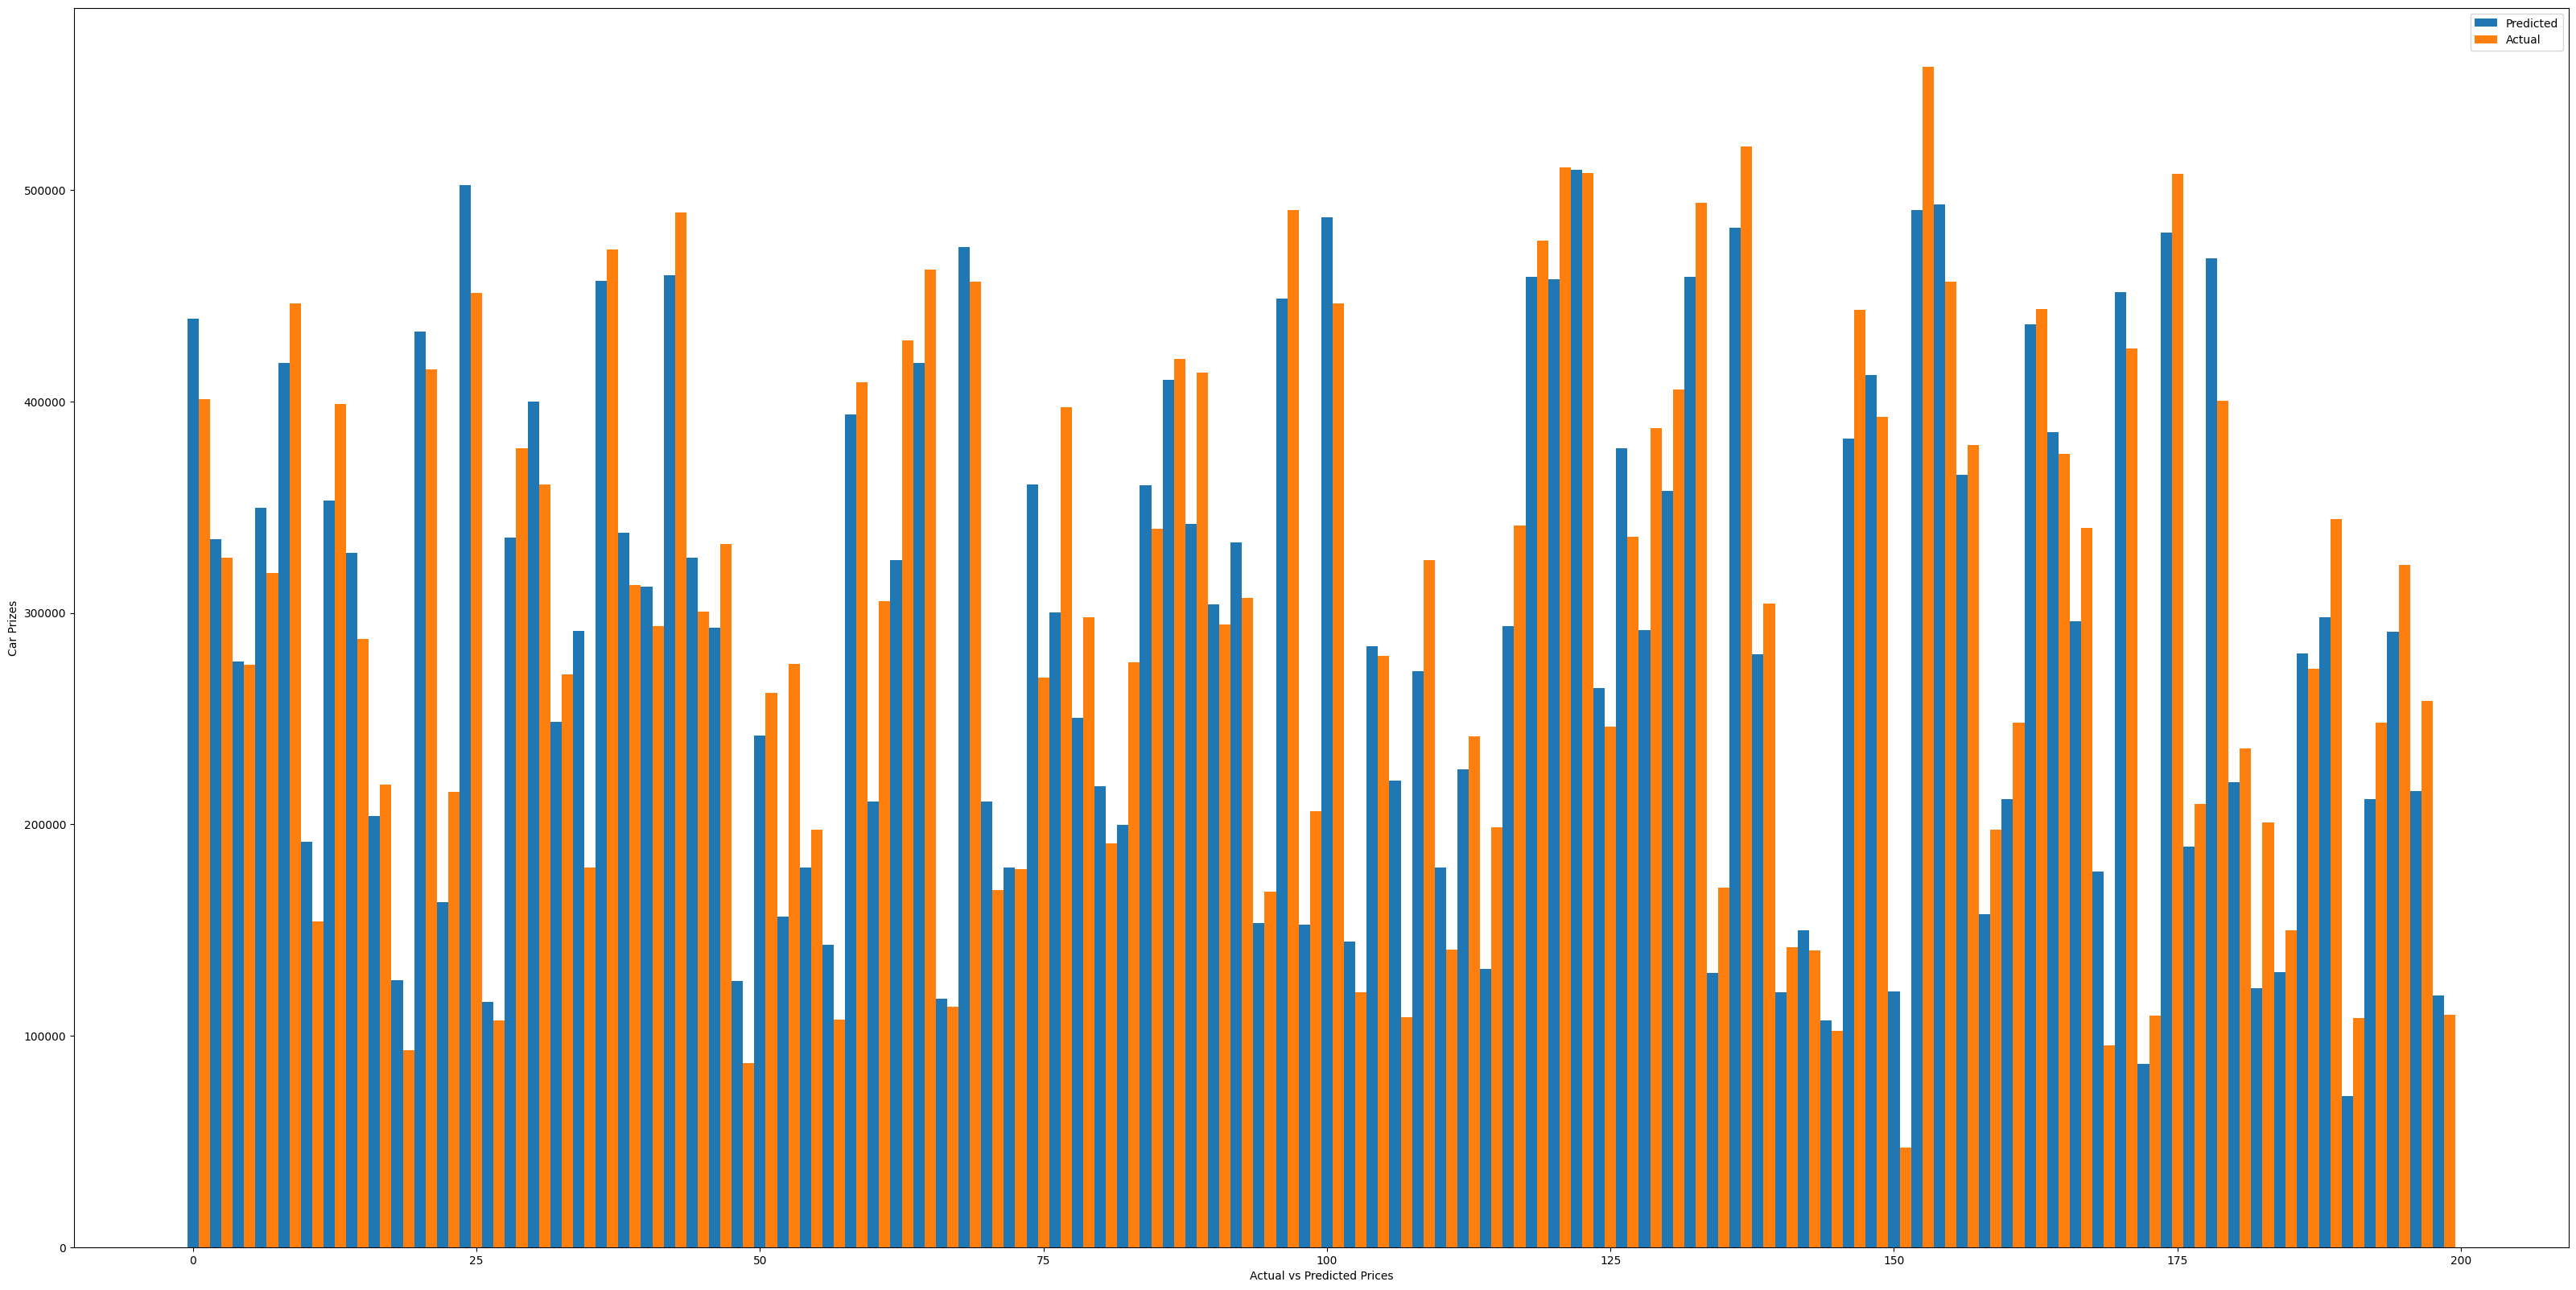

In [71]:
ind = np.arange(0, 200, 2)
print(ind)
plt.figure(figsize=(40,20))

width = 1

plt.bar(ind, y_pred, width, label = "Predicted Car Prize")
plt.bar(ind+width, y_true, width, label = "Actual Car Prize")

plt.legend(['Predicted', 'Actual'])
plt.xlabel("Actual vs Predicted Prices")
plt.ylabel("Car Prizes")

plt.show()